In [1]:
# Mount google drive
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()
    
in_folder = os.path.join(base_folder, "in")
if not os.path.exists(in_folder):
    os.makedirs(in_folder)
out_folder = os.path.join(base_folder, "out")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
character_dict = {
    'Barney':{
        'classifier_name': 'barney_classifier',
        'series_df_filename': 'HIMYM_preprocessed.csv',
        'classifier_df': 'barney_classifier.csv',
        'encoded_lines_filename': 'barney_encoded_lines.npy'
    },
    'Sheldon':{
        'classifier_name': 'sheldon_classifier'
    },
    'Harry':{
        'classifier_name': 'harry_classifier'
    },
    'Fry':{
        'classifier_name': 'fry_classifier'
    }
             }

In [4]:
batch_size = 64
epochs = 1000
lr = 1e-6
regularizer_weight_r = 1e-4
regularizer_weight_s = 1e-3
dropout_rate = 0.2
train_size = 0.85
test_size = 0.10
n_shuffles = 100

from_saved_embeddings = True

character = 'Barney'

properties = '_x100df'
shutdown_at_end = False # 'h'

In [5]:
character_folder = os.path.join(base_folder, "Data", "Characters", character)

model_path = os.path.join(character_folder, character_dict[character]['classifier_name'])

# Dataset

In [6]:
series_df = pd.read_csv(os.path.join(character_folder, character_dict[character]['series_df_filename']))

In [7]:
series_df[series_df['character']==character]

,episode,line,character
14,01x01,"hey, so you know how I've always had a thing f...",Barney
16,01x01,"Okay, meet me at the bar in fifteen minutes, a...",Barney
18,01x01,Where's your suit!? Just once when I say suit ...,Barney
20,01x01,It was a blazer!,Barney
22,01x01,I see what this is about. Have you forgotten w...,Barney
...,...,...,...
31210,08x24,I'm probably saying some political stuff right...,Barney
31214,08x24,Whoa. Is there going to be a fight?,Barney
31449,09x10,"Karate Kid bad boy Billy Zabka, a shifty-eyed ...",Barney
31557,09x15,me or you?,Barney


In [8]:
series_df['character'] = series_df['character'].apply(lambda x: 1 if x==character else 0)

In [9]:
series_df[series_df['character']==1]

,episode,line,character
14,01x01,"hey, so you know how I've always had a thing f...",1
16,01x01,"Okay, meet me at the bar in fifteen minutes, a...",1
18,01x01,Where's your suit!? Just once when I say suit ...,1
20,01x01,It was a blazer!,1
22,01x01,I see what this is about. Have you forgotten w...,1
...,...,...,...
31210,08x24,I'm probably saying some political stuff right...,1
31214,08x24,Whoa. Is there going to be a fight?,1
31449,09x10,"Karate Kid bad boy Billy Zabka, a shifty-eyed ...",1
31557,09x15,me or you?,1


In [10]:
series_df = series_df.drop(columns=['episode'])

In [11]:
classes = (0, 1)

# Model

## Sentence Transformer

In [12]:
from sentence_transformers import SentenceTransformer

if not from_saved_embeddings:
    sentence_transformer = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

In [13]:
if not from_saved_embeddings:
    sentence_transformer

## Sentence Encoding

In [14]:
if not from_saved_embeddings:

    series_df['encoded_line'] = [sentence_transformer.encode(line) for line in tqdm(series_df['line'])]

    # save sentences dataset
    series_df[['line', 'character']].to_csv(
        os.path.join(character_folder, character_dict[character]['classifier_df']), 
        index = False
    )

    np.save(
        os.path.join(character_folder, character_dict[character]['encoded_lines_filename']),
        series_df['encoded_line'].to_numpy()
    )

In [15]:
# read sentences dataaset
series_df = pd.read_csv(
    os.path.join(character_folder, character_dict[character]['classifier_df']),
    dtype={'line': str,
           'character': int
          }
)

series_df['encoded_line'] = np.load(
    os.path.join(character_folder, character_dict[character]['encoded_lines_filename']), 
    allow_pickle=True
)

In [16]:
series_df

,line,character,encoded_line
0,"Kids, I'm going to tell you an incredible stor...",0,"[-0.0060349987, 0.3398651, -0.013500607, 0.051..."
1,Are we being punished for something?,0,"[0.24517804, 0.06231432, -0.015702646, 0.03040..."
2,No,0,"[0.010471302, 0.074272856, -0.015337698, 0.099..."
3,"Yeah, is this going to take a while?",0,"[0.25085106, 0.3401538, -0.0066933706, -0.1009..."
4,"Yes. Twenty-five years ago, before I was dad,...",0,"[0.07280163, 0.24518006, -0.009924358, -0.1859..."
...,...,...,...
31771,Aunt Lily wasn't wrong.,0,"[0.008160515, 0.09477018, -0.01352677, 0.13088..."
31772,"00 a.m. Christmas morning, every sleepy Sunday...",0,"[-0.17137574, -0.0025946363, -0.008149227, 0.0..."
31773,T.M.,0,"[-0.025203055, -0.27510342, -0.010736528, 0.03..."
31774,T.M.,0,"[-0.025203055, -0.27510342, -0.010736528, 0.03..."


In [17]:
def get_triplet_df(series_df, n_shuffles=1):
    
    # separate character from others
    series_df_1 = series_df[series_df['character']==1].copy()
    series_df_0 = series_df[series_df['character']==0].copy()
    
    df_rows = {'character':[], 'encoded_lines':[]}
    
    for _ in range(n_shuffles):
        # shuffle dataset
        series_df_1 = series_df_1.sample(frac=1).reset_index(drop=True)
        series_df_0 = series_df_0.sample(n=len(series_df_1)).reset_index(drop=True)
        
        for i in tqdm(range(2,len(series_df_1))):
            # character
            lines = list(series_df_1['encoded_line'][i-2:i+1])
            lines = np.concatenate(lines)
            df_rows['character'].append(1)
            df_rows['encoded_lines'].append(lines)

            # other
            lines = list(series_df_0['encoded_line'][i-2:i+1])
            lines = np.concatenate(lines)
            df_rows['character'].append(0)
            df_rows['encoded_lines'].append(lines)

    df = pd.DataFrame(data=df_rows)
    
    return df.sample(frac=1).reset_index(drop=True)

In [18]:
shuffled_df = get_triplet_df(series_df, n_shuffles=n_shuffles)

100%|███████████████████████████████████████████████████████████████████████████| 5140/5140 [00:00<00:00, 13935.43it/s]


100%|███████████████████████████████████████████████████████████████████████████| 5140/5140 [00:00<00:00, 13730.81it/s]


In [19]:
len(shuffled_df)

1028000

## Create Classification Dataset

In [20]:
tot_len = len(shuffled_df)
train_len = int(tot_len*train_size)
test_len = int(tot_len*test_size)
val_len = tot_len - train_len - test_len

print(tot_len, train_len, test_len, val_len)

1028000 873800 102800 51400


In [21]:
print('Loading training data...')
X_train = np.array([[float(e) for e in s] for s in tqdm(shuffled_df['encoded_lines'][:train_len])])
y_train = np.array([c for c in tqdm(shuffled_df['character'][:train_len])])

print('Loading test data...')
X_test = np.array([[float(e) for e in s] for s in tqdm(shuffled_df['encoded_lines'][:test_len])])
y_test = np.array([c for c in tqdm(shuffled_df['character'][:test_len])])

print('Loading validation data...')
X_val = np.array([[float(e) for e in s] for s in tqdm(shuffled_df['encoded_lines'][:val_len])])
y_val = np.array([c for c in tqdm(shuffled_df['character'][:val_len])])

Loading training data...


100%|██████████████████████████████████████████████████████████████████████| 873800/873800 [00:01<00:00, 550026.01it/s]


Loading test data...


100%|█████████████████████████████████████████████████████████████████████| 102800/102800 [00:00<00:00, 3020825.11it/s]


Loading validation data...


100%|███████████████████████████████████████████████████████████████████████| 51400/51400 [00:00<00:00, 2232791.94it/s]


In [22]:
# compute some statistics
train_percentage_1 = len(y_train[y_train==1])/len(y_train)
train_percentage_0 = len(y_train[y_train==0])/len(y_train)

val_percentage_1 = len(y_val[y_val==1])/len(y_val)
val_percentage_0 = len(y_val[y_val==0])/len(y_val)
print('\t0 (%)\t\t1 (%)')
print('train\t{:.2f}\t\t{:.2f}'.format(train_percentage_0, train_percentage_1))
print('val\t{:.2f}\t\t{:.2f}'.format(val_percentage_0, val_percentage_1))

	0 (%)		1 (%)
train	0.50		0.50
val	0.50		0.50


## Classification Model

In [23]:
# Import keras/tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

In [24]:
# create model
def create_model():
    inputs = keras.Input(shape=(len(X_train[0],)))
    
    x = layers.Dense(
        1024,
        activation='relu',
        # kernel_regularizer=regularizers.l2(regularizer_weight),
        # bias_regularizer=regularizers.l2(regularizer_weight)
    )(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
        1024,
        activation='relu',
        # kernel_regularizer=regularizers.l2(regularizer_weight),
        # bias_regularizer=regularizers.l2(regularizer_weight)
    )(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
        512, 
        activation='relu',
        # kernel_regularizer=regularizers.l2(regularizer_weight),
        # bias_regularizer=regularizers.l2(regularizer_weight)
    )(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
        256, 
        activation='relu',
        # kernel_regularizer=regularizers.l2(regularizer_weight),
        # bias_regularizer=regularizers.l2(regularizer_weight)
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=regularizers.l2(regularizer_weight_r),
        bias_regularizer=regularizers.l2(regularizer_weight_r)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(regularizer_weight_s),
        bias_regularizer=regularizers.l2(regularizer_weight_s)
    )(x)


    classifier_model = keras.Model(inputs, out)
    classifier_model.compile(
        loss = keras.losses.BinaryCrossentropy(),
        optimizer = keras.optimizers.Adam(learning_rate = lr),
        metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Recall()]
    )
    return classifier_model

In [25]:
classifier_model = create_model()

## Training

In [26]:
earlystop_callback = callbacks.EarlyStopping(
        monitor="val_binary_accuracy",
        min_delta=0,
        patience=6,
        verbose=0,
        mode="max",
        baseline=None,
        restore_best_weights=True,
    )

In [27]:
train_history = classifier_model.fit(
    X_train, 
    y_train,
    validation_data = (X_val, y_val),
    epochs= epochs,
    verbose = 1, 
    callbacks=[earlystop_callback],
    batch_size = batch_size
)

Epoch 1/1000
13654/13654 [==============================] - 220s 16ms/step - loss: 0.8207 - binary_accuracy: 0.5636 - recall: 0.5702 - val_loss: 0.7068 - val_binary_accuracy: 0.6198 - val_recall: 0.6066
Epoch 2/1000
13654/13654 [==============================] - 212s 16ms/step - loss: 0.7216 - binary_accuracy: 0.6238 - recall: 0.6287 - val_loss: 0.6401 - val_binary_accuracy: 0.6704 - val_recall: 0.6578
Epoch 3/1000
13654/13654 [==============================] - 213s 16ms/step - loss: 0.6670 - binary_accuracy: 0.6597 - recall: 0.6641 - val_loss: 0.5930 - val_binary_accuracy: 0.7049 - val_recall: 0.6936
Epoch 4/1000
13654/13654 [==============================] - 213s 16ms/step - loss: 0.6254 - binary_accuracy: 0.6875 - recall: 0.6915 - val_loss: 0.5542 - val_binary_accuracy: 0.7316 - val_recall: 0.7208
Epoch 5/1000
13654/13654 [==============================] - 212s 16ms/step - loss: 0.5901 - binary_accuracy: 0.7105 - recall: 0.7143 - val_loss: 0.5208 - val_binary_accuracy: 0.7533 - val_

13654/13654 [==============================] - 201s 15ms/step - loss: 0.0649 - binary_accuracy: 0.9828 - recall: 0.9834 - val_loss: 0.0313 - val_binary_accuracy: 0.9979 - val_recall: 0.9979
Epoch 42/1000
13654/13654 [==============================] - 210s 15ms/step - loss: 0.0620 - binary_accuracy: 0.9839 - recall: 0.9843 - val_loss: 0.0294 - val_binary_accuracy: 0.9985 - val_recall: 0.9988
Epoch 43/1000
13654/13654 [==============================] - 211s 15ms/step - loss: 0.0592 - binary_accuracy: 0.9850 - recall: 0.9855 - val_loss: 0.0281 - val_binary_accuracy: 0.9987 - val_recall: 0.9990
Epoch 44/1000
13654/13654 [==============================] - 213s 16ms/step - loss: 0.0564 - binary_accuracy: 0.9861 - recall: 0.9866 - val_loss: 0.0267 - val_binary_accuracy: 0.9992 - val_recall: 0.9993
Epoch 45/1000
13654/13654 [==============================] - 212s 16ms/step - loss: 0.0544 - binary_accuracy: 0.9869 - recall: 0.9873 - val_loss: 0.0255 - val_binary_accuracy: 0.9994 - val_recall: 0

######################### Model Test #########################


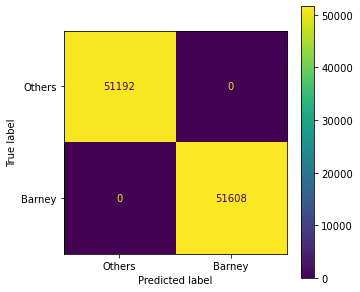

In [28]:
print('#'*25 + ' Model Test ' + '#'*25)
fig, ax=plt.subplots(1,1,figsize=(5,5))
y_pred = classifier_model.predict(X_test).round()
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix(y_test, y_pred) #, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', character])
disp.plot(ax=ax)
plt.show()

In [29]:
classifier_path = os.path.join(character_folder, character_dict[character]['classifier_name']+properties)
classifier_model.save(classifier_path)

INFO:tensorflow:Assets written to: C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\Data\Characters\Barney\barney_classifier_x100df\assets


In [30]:
# Save history as a JSON file
import json
filename = character.lower() + '_training_history' + properties + '.json'

output_string = json.dumps(train_history.history)
with open(os.path.join(character_folder, filename), 'w') as file:
    file.write(output_string)

In [31]:
if shutdown_at_end:
    os.system('shutdown /' + shutdown_at_end)